# Mounting Google drive to google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TO be deleted
import os
os.chdir('/content/drive/MyDrive/new_cycle/StarGANv2-VC')

# Importing needed libraries

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install SoundFile torchaudio munch parallel_wavegan torch pydub pyyaml click librosa
clear_output()

In [ ]:
import os
import os.path as osp
import re
import sys
import yaml
import copy
import math
import shutil
import numpy as np
import random


import torch
from torch import nn
from torch.optim import Optimizer
from torch.optim import AdamW
import torch.nn.functional as F
import torchaudio
import torchaudio.functional as audio_F

from PIL import Image
from tqdm import tqdm

import click
import time
import warnings
warnings.simplefilter('ignore')

from functools import reduce
from munch import Munch
from collections import defaultdict

from meldataset import build_dataloader
#from optimizers import build_optimizer
#from models import build_model
from torch.utils.tensorboard import SummaryWriter
#from losses import compute_d_loss, compute_g_loss

from Utils.ASR.models import ASRCNN
from Utils.JDC.model import JDCNet

import logging
from logging import StreamHandler
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
handler = StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)


# Writing model configurations in yml file

In [ ]:
%%writefile ./Configs/config.yml

log_dir: "Models/VCTK20"
save_freq: 999
device: "cuda"
epochs: 501
batch_size: 16
pretrained_model: "Models/VCTK20/epoch_00499.pth"
load_only_params: false
fp16_run: true

train_data: "Data/train_list.txt"
val_data: "Data/val_list.txt"

F0_path: "Utils/JDC/bst.t7"
ASR_config: "Utils/ASR/config.yml"
ASR_path: "Utils/ASR/epoch_00100.pth"

preprocess_params:
  sr: 24000
  spect_params:
    n_fft: 2048
    win_length: 1200
    hop_length: 300

model_params:
  dim_in: 64
  style_dim: 64
  latent_dim: 16
  num_domains: 2
  max_conv_dim: 512
  n_repeat: 4
  w_hpf: 0
  F0_channel: 256

loss_params:
  g_loss:
    lambda_sty: 1.
    lambda_cyc: 5.
    lambda_ds: 1.
    lambda_norm: 1.
    lambda_asr: 10.
    lambda_f0: 5.
    lambda_f0_sty: 0.1
    lambda_adv: 2.
    lambda_adv_cls: 0.5
    norm_bias: 0.5
  d_loss:
    lambda_reg: 1.
    lambda_adv_cls: 0.1
    lambda_con_reg: 10.

  adv_cls_epoch: 50
  con_reg_epoch: 30

optimizer_params:
  lr: 0.0001

Overwriting ./Configs/config.yml


# Training

losses.py

In [ ]:
def compute_d_loss(nets, args, x_real, y_org, y_trg, z_trg=None, x_ref=None, use_r1_reg=True, use_adv_cls=False, use_con_reg=False):
    args = Munch(args)

    assert (z_trg is None) != (x_ref is None)
    # with real audios
    x_real.requires_grad_()
    out = nets.discriminator(x_real, y_org)
    loss_real = adv_loss(out, 1)

    # R1 regularizaition (https://arxiv.org/abs/1801.04406v4)
    if use_r1_reg:
        loss_reg = r1_reg(out, x_real)
    else:
        loss_reg = torch.FloatTensor([0]).to(x_real.device)

    # consistency regularization (bCR-GAN: https://arxiv.org/abs/2002.04724)
    loss_con_reg = torch.FloatTensor([0]).to(x_real.device)
    if use_con_reg:
        t = build_transforms()
        out_aug = nets.discriminator(t(x_real).detach(), y_org)
        loss_con_reg += F.smooth_l1_loss(out, out_aug)

    # with fake audios
    with torch.no_grad():
        if z_trg is not None:
            s_trg = nets.mapping_network(z_trg, y_trg)
        else:  # x_ref is not None
            s_trg = nets.style_encoder(x_ref, y_trg)

        F0 = nets.f0_model.get_feature_GAN(x_real)
        x_fake = nets.generator(x_real, s_trg, masks=None, F0=F0)
    out = nets.discriminator(x_fake, y_trg)
    loss_fake = adv_loss(out, 0)
    if use_con_reg:
        out_aug = nets.discriminator(t(x_fake).detach(), y_trg)
        loss_con_reg += F.smooth_l1_loss(out, out_aug)

    # adversarial classifier loss
    if use_adv_cls:
        out_de = nets.discriminator.classifier(x_fake)
        loss_real_adv_cls = F.cross_entropy(out_de[y_org != y_trg], y_org[y_org != y_trg])

        if use_con_reg:
            out_de_aug = nets.discriminator.classifier(t(x_fake).detach())
            loss_con_reg += F.smooth_l1_loss(out_de, out_de_aug)
    else:
        loss_real_adv_cls = torch.zeros(1).mean()

    loss = loss_real + loss_fake + args.lambda_reg * loss_reg + \
            args.lambda_adv_cls * loss_real_adv_cls + \
            args.lambda_con_reg * loss_con_reg

    return loss, Munch(real=loss_real.item(),
                       fake=loss_fake.item(),
                       reg=loss_reg.item(),
                       real_adv_cls=loss_real_adv_cls.item(),
                       con_reg=loss_con_reg.item())

def compute_g_loss(nets, args, x_real, y_org, y_trg, z_trgs=None, x_refs=None, use_adv_cls=False):
    args = Munch(args)

    assert (z_trgs is None) != (x_refs is None)
    if z_trgs is not None:
        z_trg, z_trg2 = z_trgs
    if x_refs is not None:
        x_ref, x_ref2 = x_refs

    # compute style vectors
    if z_trgs is not None:
        s_trg = nets.mapping_network(z_trg, y_trg)
    else:
        s_trg = nets.style_encoder(x_ref, y_trg)

    # compute ASR/F0 features (real)
    with torch.no_grad():
        F0_real, GAN_F0_real, cyc_F0_real = nets.f0_model(x_real)
        ASR_real = nets.asr_model.get_feature(x_real)

    # adversarial loss
    x_fake = nets.generator(x_real, s_trg, masks=None, F0=GAN_F0_real)
    out = nets.discriminator(x_fake, y_trg)
    loss_adv = adv_loss(out, 1)

    # compute ASR/F0 features (fake)
    F0_fake, GAN_F0_fake, _ = nets.f0_model(x_fake)
    ASR_fake = nets.asr_model.get_feature(x_fake)

    # norm consistency loss
    x_fake_norm = log_norm(x_fake)
    x_real_norm = log_norm(x_real)
    loss_norm = ((torch.nn.ReLU()(torch.abs(x_fake_norm - x_real_norm) - args.norm_bias))**2).mean()

    # F0 loss
    loss_f0 = f0_loss(F0_fake, F0_real)

    # style F0 loss (style initialization)
    if x_refs is not None and args.lambda_f0_sty > 0 and not use_adv_cls:
        F0_sty, _, _ = nets.f0_model(x_ref)
        loss_f0_sty = F.l1_loss(compute_mean_f0(F0_fake), compute_mean_f0(F0_sty))
    else:
        loss_f0_sty = torch.zeros(1).mean()

    # ASR loss
    loss_asr = F.smooth_l1_loss(ASR_fake, ASR_real)

    # style reconstruction loss
    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = torch.mean(torch.abs(s_pred - s_trg))

    # diversity sensitive loss
    if z_trgs is not None:
        s_trg2 = nets.mapping_network(z_trg2, y_trg)
    else:
        s_trg2 = nets.style_encoder(x_ref2, y_trg)
    x_fake2 = nets.generator(x_real, s_trg2, masks=None, F0=GAN_F0_real)
    x_fake2 = x_fake2.detach()
    _, GAN_F0_fake2, _ = nets.f0_model(x_fake2)
    loss_ds = torch.mean(torch.abs(x_fake - x_fake2))
    loss_ds += F.smooth_l1_loss(GAN_F0_fake, GAN_F0_fake2.detach())

    # cycle-consistency loss
    s_org = nets.style_encoder(x_real, y_org)
    x_rec = nets.generator(x_fake, s_org, masks=None, F0=GAN_F0_fake)
    loss_cyc = torch.mean(torch.abs(x_rec - x_real))
    # F0 loss in cycle-consistency loss
    if args.lambda_f0 > 0:
        _, _, cyc_F0_rec = nets.f0_model(x_rec)
        loss_cyc += F.smooth_l1_loss(cyc_F0_rec, cyc_F0_real)
    if args.lambda_asr > 0:
        ASR_recon = nets.asr_model.get_feature(x_rec)
        loss_cyc += F.smooth_l1_loss(ASR_recon, ASR_real)

    # adversarial classifier loss
    if use_adv_cls:
        out_de = nets.discriminator.classifier(x_fake)
        loss_adv_cls = F.cross_entropy(out_de[y_org != y_trg], y_trg[y_org != y_trg])
    else:
        loss_adv_cls = torch.zeros(1).mean()

    loss = args.lambda_adv * loss_adv + args.lambda_sty * loss_sty \
           - args.lambda_ds * loss_ds + args.lambda_cyc * loss_cyc\
           + args.lambda_norm * loss_norm \
           + args.lambda_asr * loss_asr \
           + args.lambda_f0 * loss_f0 \
           + args.lambda_f0_sty * loss_f0_sty \
           + args.lambda_adv_cls * loss_adv_cls

    return loss, Munch(adv=loss_adv.item(),
                       sty=loss_sty.item(),
                       ds=loss_ds.item(),
                       cyc=loss_cyc.item(),
                       norm=loss_norm.item(),
                       asr=loss_asr.item(),
                       f0=loss_f0.item(),
                       adv_cls=loss_adv_cls.item())

# for norm consistency loss
def log_norm(x, mean=-4, std=4, dim=2):
    """
    normalized log mel -> mel -> norm -> log(norm)
    """
    x = torch.log(torch.exp(x * std + mean).norm(dim=dim))
    return x

# for adversarial loss
def adv_loss(logits, target):
    assert target in [1, 0]
    if len(logits.shape) > 1:
        logits = logits.reshape(-1)
    targets = torch.full_like(logits, fill_value=target)
    logits = logits.clamp(min=-10, max=10) # prevent nan
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss

# for R1 regularization loss
def r1_reg(d_out, x_in):
    # zero-centered gradient penalty for real images
    batch_size = x_in.size(0)
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

# for F0 consistency loss
def compute_mean_f0(f0):
    f0_mean = f0.mean(-1)
    f0_mean = f0_mean.expand(f0.shape[-1], f0_mean.shape[0]).transpose(0, 1) # (B, M)
    return f0_mean

def f0_loss(x_f0, y_f0):
    """
    x.shape = (B, 1, M, L): predict
    y.shape = (B, 1, M, L): target
    """
    # compute the mean
    x_mean = compute_mean_f0(x_f0)
    y_mean = compute_mean_f0(y_f0)
    loss = F.l1_loss(x_f0 / x_mean, y_f0 / y_mean)
    return loss

transformers.py

In [ ]:

## 1. RandomTimeStrech

class TimeStrech(nn.Module):
    def __init__(self, scale):
        super(TimeStrech, self).__init__()
        self.scale = scale

    def forward(self, x):
        mel_size = x.size(-1)

        x = F.interpolate(x, scale_factor=(1, self.scale), align_corners=False,
                          recompute_scale_factor=True, mode='bilinear').squeeze()

        if x.size(-1) < mel_size:
            noise_length = (mel_size - x.size(-1))
            random_pos = random.randint(0, x.size(-1)) - noise_length
            if random_pos < 0:
                random_pos = 0
            noise = x[..., random_pos:random_pos + noise_length]
            x = torch.cat([x, noise], dim=-1)
        else:
            x = x[..., :mel_size]

        return x.unsqueeze(1)

## 2. PitchShift
class PitchShift(nn.Module):
    def __init__(self, shift):
        super(PitchShift, self).__init__()
        self.shift = shift

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        x = x.squeeze()
        mel_size = x.shape[1]
        shift_scale = (mel_size + self.shift) / mel_size
        x = F.interpolate(x.unsqueeze(1), scale_factor=(shift_scale, 1.), align_corners=False,
                          recompute_scale_factor=True, mode='bilinear').squeeze(1)

        x = x[:, :mel_size]
        if x.size(1) < mel_size:
            pad_size = mel_size - x.size(1)
            x = torch.cat([x, torch.zeros(x.size(0), pad_size, x.size(2)).to(x.device)], dim=1)
        x = x.squeeze()
        return x.unsqueeze(1)

## 3. ShiftBias
class ShiftBias(nn.Module):
    def __init__(self, bias):
        super(ShiftBias, self).__init__()
        self.bias = bias

    def forward(self, x):
        return x + self.bias

## 4. Scaling
class SpectScaling(nn.Module):
    def __init__(self, scale):
        super(SpectScaling, self).__init__()
        self.scale = scale

    def forward(self, x):
        return x * self.scale

## 5. Time Flip
class TimeFlip(nn.Module):
    def __init__(self, length):
        super(TimeFlip, self).__init__()
        self.length = round(length)

    def forward(self, x):
        if self.length > 1:
          start = np.random.randint(0, x.shape[-1] - self.length)
          x_ret = x.clone()
          x_ret[..., start:start + self.length] = torch.flip(x[..., start:start + self.length], dims=[-1])
          x = x_ret
        return x

class PhaseShuffle2d(nn.Module):
    def __init__(self, n=2):
        super(PhaseShuffle2d, self).__init__()
        self.n = n
        self.random = random.Random(1)

    def forward(self, x, move=None):
        # x.size = (B, C, M, L)
        if move is None:
            move = self.random.randint(-self.n, self.n)

        if move == 0:
            return x
        else:
            left = x[:, :, :, :move]
            right = x[:, :, :, move:]
            shuffled = torch.cat([right, left], dim=3)

        return shuffled

def build_transforms():
    transforms = [
        lambda M: TimeStrech(1+ (np.random.random()-0.5)*M*0.2),
        lambda M: SpectScaling(1 + (np.random.random()-1)*M*0.1),
        lambda M: PhaseShuffle2d(192),
    ]
    N, M = len(transforms), np.random.random()
    composed = nn.Sequential(
        *[trans(M) for trans in np.random.choice(transforms, N)]
    )
    return composed

model.py

In [ ]:
class DownSample(nn.Module):
    def __init__(self, layer_type):
        super().__init__()
        self.layer_type = layer_type

    def forward(self, x):
        if self.layer_type == 'none':
            return x
        elif self.layer_type == 'timepreserve':
            return F.avg_pool2d(x, (2, 1))
        elif self.layer_type == 'half':
            return F.avg_pool2d(x, 2)
        else:
            raise RuntimeError('Got unexpected donwsampletype %s, expected is [none, timepreserve, half]' % self.layer_type)


class UpSample(nn.Module):
    def __init__(self, layer_type):
        super().__init__()
        self.layer_type = layer_type

    def forward(self, x):
        if self.layer_type == 'none':
            return x
        elif self.layer_type == 'timepreserve':
            return F.interpolate(x, scale_factor=(2, 1), mode='nearest')
        elif self.layer_type == 'half':
            return F.interpolate(x, scale_factor=2, mode='nearest')
        else:
            raise RuntimeError('Got unexpected upsampletype %s, expected is [none, timepreserve, half]' % self.layer_type)


class ResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, actv=nn.LeakyReLU(0.2),
                 normalize=False, downsample='none'):
        super().__init__()
        self.actv = actv
        self.normalize = normalize
        self.downsample = DownSample(downsample)
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out)

    def _build_weights(self, dim_in, dim_out):
        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            x = self.downsample(x)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        x = self.conv1(x)
        x = self.downsample(x)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self._shortcut(x) + self._residual(x)
        return x / math.sqrt(2)  # unit variance

class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta


class AdainResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=64, w_hpf=0,
                 actv=nn.LeakyReLU(0.2), upsample='none'):
        super().__init__()
        self.w_hpf = w_hpf
        self.actv = actv
        self.upsample = UpSample(upsample)
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out, style_dim)

    def _build_weights(self, dim_in, dim_out, style_dim=64):
        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.norm2 = AdaIN(style_dim, dim_out)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        x = self.upsample(x)
        if self.learned_sc:
            x = self.conv1x1(x)
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.actv(x)
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.norm2(x, s)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x, s):
        out = self._residual(x, s)
        if self.w_hpf == 0:
            out = (out + self._shortcut(x)) / math.sqrt(2)
        return out


class HighPass(nn.Module):
    def __init__(self, w_hpf, device):
        super(HighPass, self).__init__()
        self.filter = torch.tensor([[-1, -1, -1],
                                    [-1, 8., -1],
                                    [-1, -1, -1]]).to(device) / w_hpf

    def forward(self, x):
        filter = self.filter.unsqueeze(0).unsqueeze(1).repeat(x.size(1), 1, 1, 1)
        return F.conv2d(x, filter, padding=1, groups=x.size(1))


class Generator(nn.Module):
    def __init__(self, dim_in=48, style_dim=48, max_conv_dim=48*8, w_hpf=1, F0_channel=0):
        super().__init__()

        self.stem = nn.Conv2d(1, dim_in, 3, 1, 1)
        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()
        self.to_out = nn.Sequential(
            nn.InstanceNorm2d(dim_in, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, 1, 1, 1, 0))
        self.F0_channel = F0_channel
        # down/up-sampling blocks
        repeat_num = 4 #int(np.log2(img_size)) - 4
        if w_hpf > 0:
            repeat_num += 1

        for lid in range(repeat_num):
            if lid in [1, 3]:
                _downtype = 'timepreserve'
            else:
                _downtype = 'half'

            dim_out = min(dim_in*2, max_conv_dim)
            self.encode.append(
                ResBlk(dim_in, dim_out, normalize=True, downsample=_downtype))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_in, style_dim,
                               w_hpf=w_hpf, upsample=_downtype))  # stack-like
            dim_in = dim_out

        # bottleneck blocks (encoder)
        for _ in range(2):
            self.encode.append(
                ResBlk(dim_out, dim_out, normalize=True))

        # F0 blocks
        if F0_channel != 0:
            self.decode.insert(
                0, AdainResBlk(dim_out + int(F0_channel / 2), dim_out, style_dim, w_hpf=w_hpf))

        # bottleneck blocks (decoder)
        for _ in range(2):
            self.decode.insert(
                    0, AdainResBlk(dim_out + int(F0_channel / 2), dim_out + int(F0_channel / 2), style_dim, w_hpf=w_hpf))

        if F0_channel != 0:
            self.F0_conv = nn.Sequential(
                ResBlk(F0_channel, int(F0_channel / 2), normalize=True, downsample="half"),
            )


        if w_hpf > 0:
            device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
            self.hpf = HighPass(w_hpf, device)

    def forward(self, x, s, masks=None, F0=None):
        x = self.stem(x)
        cache = {}
        for block in self.encode:
            if (masks is not None) and (x.size(2) in [32, 64, 128]):
                cache[x.size(2)] = x
            x = block(x)

        if F0 is not None:
            F0 = self.F0_conv(F0)
            F0 = F.adaptive_avg_pool2d(F0, [x.shape[-2], x.shape[-1]])
            x = torch.cat([x, F0], axis=1)

        for block in self.decode:
            x = block(x, s)
            if (masks is not None) and (x.size(2) in [32, 64, 128]):
                mask = masks[0] if x.size(2) in [32] else masks[1]
                mask = F.interpolate(mask, size=x.size(2), mode='bilinear')
                x = x + self.hpf(mask * cache[x.size(2)])

        return self.to_out(x)


class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=48, num_domains=2, hidden_dim=384):
        super().__init__()
        layers = []
        layers += [nn.Linear(latent_dim, hidden_dim)]
        layers += [nn.ReLU()]
        for _ in range(3):
            layers += [nn.Linear(hidden_dim, hidden_dim)]
            layers += [nn.ReLU()]
        self.shared = nn.Sequential(*layers)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                            nn.ReLU(),
                                            nn.Linear(hidden_dim, hidden_dim),
                                            nn.ReLU(),
                                            nn.Linear(hidden_dim, hidden_dim),
                                            nn.ReLU(),
                                            nn.Linear(hidden_dim, style_dim))]

    def forward(self, z, y):
        h = self.shared(z)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s


class StyleEncoder(nn.Module):
    def __init__(self, dim_in=48, style_dim=48, num_domains=2, max_conv_dim=384):
        super().__init__()
        blocks = []
        blocks += [nn.Conv2d(1, dim_in, 3, 1, 1)]

        repeat_num = 4
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample='half')]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 5, 1, 0)]
        blocks += [nn.AdaptiveAvgPool2d(1)]
        blocks += [nn.LeakyReLU(0.2)]
        self.shared = nn.Sequential(*blocks)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Linear(dim_out, style_dim)]

    def forward(self, x, y):
        h = self.shared(x)

        h = h.view(h.size(0), -1)
        out = []

        for layer in self.unshared:
            out += [layer(h)]

        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s

class Discriminator(nn.Module):
    def __init__(self, dim_in=48, num_domains=2, max_conv_dim=384, repeat_num=4):
        super().__init__()

        # real/fake discriminator
        self.dis = Discriminator2d(dim_in=dim_in, num_domains=num_domains,
                                  max_conv_dim=max_conv_dim, repeat_num=repeat_num)
        # adversarial classifier
        self.cls = Discriminator2d(dim_in=dim_in, num_domains=num_domains,
                                  max_conv_dim=max_conv_dim, repeat_num=repeat_num)
        self.num_domains = num_domains

    def forward(self, x, y):
        return self.dis(x, y)

    def classifier(self, x):
        return self.cls.get_feature(x)


class LinearNorm(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

        torch.nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear_layer(x)

class Discriminator2d(nn.Module):
    def __init__(self, dim_in=48, num_domains=2, max_conv_dim=384, repeat_num=4):
        super().__init__()
        blocks = []
        blocks += [nn.Conv2d(1, dim_in, 3, 1, 1)]

        for lid in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample='half')]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 5, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.AdaptiveAvgPool2d(1)]
        blocks += [nn.Conv2d(dim_out, num_domains, 1, 1, 0)]
        self.main = nn.Sequential(*blocks)

    def get_feature(self, x):
        out = self.main(x)
        out = out.view(out.size(0), -1)  # (batch, num_domains)
        return out

    def forward(self, x, y):
        out = self.get_feature(x)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        out = out[idx, y]  # (batch)
        return out


def build_model(args, F0_model, ASR_model):
    generator = Generator(args.dim_in, args.style_dim, args.max_conv_dim, w_hpf=args.w_hpf, F0_channel=args.F0_channel)
    mapping_network = MappingNetwork(args.latent_dim, args.style_dim, args.num_domains, hidden_dim=args.max_conv_dim)
    style_encoder = StyleEncoder(args.dim_in, args.style_dim, args.num_domains, args.max_conv_dim)
    discriminator = Discriminator(args.dim_in, args.num_domains, args.max_conv_dim, args.n_repeat)
    generator_ema = copy.deepcopy(generator)
    mapping_network_ema = copy.deepcopy(mapping_network)
    style_encoder_ema = copy.deepcopy(style_encoder)

    nets = Munch(generator=generator,
                 mapping_network=mapping_network,
                 style_encoder=style_encoder,
                 discriminator=discriminator,
                 f0_model=F0_model,
                 asr_model=ASR_model)

    nets_ema = Munch(generator=generator_ema,
                     mapping_network=mapping_network_ema,
                     style_encoder=style_encoder_ema)

    return nets, nets_ema

Optimezer.py

In [ ]:
class MultiOptimizer:
    def __init__(self, optimizers={}, schedulers={}):
        self.optimizers = optimizers
        self.schedulers = schedulers
        self.keys = list(optimizers.keys())
        self.param_groups = reduce(lambda x,y: x+y, [v.param_groups for v in self.optimizers.values()])

    def state_dict(self):
        state_dicts = [(key, self.optimizers[key].state_dict())\
                       for key in self.keys]
        return state_dicts

    def load_state_dict(self, state_dict):
        for key, val in state_dict:
            try:
                self.optimizers[key].load_state_dict(val)
            except:
                print("Unloaded %s" % key)

    def step(self, key=None, scaler=None):
        keys = [key] if key is not None else self.keys
        _ = [self._step(key, scaler) for key in keys]

    def _step(self, key, scaler=None):
        if scaler is not None:
            scaler.step(self.optimizers[key])
            scaler.update()
        else:
            self.optimizers[key].step()

    def zero_grad(self, key=None):
        if key is not None:
            self.optimizers[key].zero_grad()
        else:
            _ = [self.optimizers[key].zero_grad() for key in self.keys]

    def scheduler(self, *args, key=None):
        if key is not None:
            self.schedulers[key].step(*args)
        else:
            _ = [self.schedulers[key].step(*args) for key in self.keys]

def define_scheduler(optimizer, params):
    print(params)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=params.get('max_lr', 2e-4),
        epochs=params.get('epochs', 200),
        steps_per_epoch=params.get('steps_per_epoch', 1000),
        pct_start=params.get('pct_start', 0.0),
        div_factor=1,
        final_div_factor=1)

    return scheduler

def build_optimizer(parameters_dict, scheduler_params_dict):
    optim = dict([(key, AdamW(params, lr=1e-4, weight_decay=1e-4, betas=(0.0, 0.99), eps=1e-9))
                   for key, params in parameters_dict.items()])

    schedulers = dict([(key, define_scheduler(opt, scheduler_params_dict[key])) \
                       for key, opt in optim.items()])

    multi_optim = MultiOptimizer(optim, schedulers)
    return multi_optim

trainer.py

In [ ]:
class Trainer(object):
    def __init__(self,
                 args,
                 model=None,
                 model_ema=None,
                 optimizer=None,
                 scheduler=None,
                 config={},
                 device=torch.device("cpu"),
                 logger=logger,
                 train_dataloader=None,
                 val_dataloader=None,
                 initial_steps=0,
                 initial_epochs=0,
                 fp16_run=False
    ):
        self.args = args
        self.steps = initial_steps
        self.epochs = initial_epochs
        self.model = model
        self.model_ema = model_ema
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.config = config
        self.device = device
        self.finish_train = False
        self.logger = logger
        self.fp16_run = fp16_run

    def _train_epoch(self):
        """Train model one epoch."""
        raise NotImplementedError

    @torch.no_grad()
    def _eval_epoch(self):
        """Evaluate model one epoch."""
        pass

    def save_checkpoint(self, checkpoint_path):
        """Save checkpoint.
        Args:
            checkpoint_path (str): Checkpoint path to be saved.
        """
        state_dict = {
            "optimizer": self.optimizer.state_dict(),
            "steps": self.steps,
            "epochs": self.epochs,
            "model": {key: self.model[key].state_dict() for key in self.model}
        }
        if self.model_ema is not None:
            state_dict['model_ema'] = {key: self.model_ema[key].state_dict() for key in self.model_ema}

        if not os.path.exists(os.path.dirname(checkpoint_path)):
            os.makedirs(os.path.dirname(checkpoint_path))
        torch.save(state_dict, checkpoint_path)

    def load_checkpoint(self, checkpoint_path, load_only_params=False):
        """Load checkpoint.

        Args:
            checkpoint_path (str): Checkpoint path to be loaded.
            load_only_params (bool): Whether to load only model parameters.

        """
        state_dict = torch.load(checkpoint_path, map_location="cpu")
        for key in self.model:
            self._load(state_dict["model"][key], self.model[key])

        if self.model_ema is not None:
            for key in self.model_ema:
                self._load(state_dict["model_ema"][key], self.model_ema[key])

        if not load_only_params:
            self.steps = state_dict["steps"]
            self.epochs = state_dict["epochs"]
            self.optimizer.load_state_dict(state_dict["optimizer"])


    def _load(self, states, model, force_load=True):
        model_states = model.state_dict()
        for key, val in states.items():
            try:
                if key not in model_states:
                    continue
                if isinstance(val, nn.Parameter):
                    val = val.data

                if val.shape != model_states[key].shape:
                    self.logger.info("%s does not have same shape" % key)
                    print(val.shape, model_states[key].shape)
                    if not force_load:
                        continue

                    min_shape = np.minimum(np.array(val.shape), np.array(model_states[key].shape))
                    slices = [slice(0, min_index) for min_index in min_shape]
                    model_states[key][slices].copy_(val[slices])
                else:
                    model_states[key].copy_(val)
            except:
                self.logger.info("not exist :%s" % key)
                print("not exist ", key)

    @staticmethod
    def get_gradient_norm(model):
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2

        total_norm = np.sqrt(total_norm)
        return total_norm

    @staticmethod
    def length_to_mask(lengths):
        mask = torch.arange(lengths.max()).unsqueeze(0).expand(lengths.shape[0], -1).type_as(lengths)
        mask = torch.gt(mask+1, lengths.unsqueeze(1))
        return mask

    def _get_lr(self):
        for param_group in self.optimizer.param_groups:
            lr = param_group['lr']
            break
        return lr

    @staticmethod
    def moving_average(model, model_test, beta=0.999):
        for param, param_test in zip(model.parameters(), model_test.parameters()):
            param_test.data = torch.lerp(param.data, param_test.data, beta)

    def _train_epoch(self):
        self.epochs += 1

        train_losses = defaultdict(list)
        _ = [self.model[k].train() for k in self.model]
        scaler = torch.cuda.amp.GradScaler() if (('cuda' in str(self.device)) and self.fp16_run) else None

        use_con_reg = (self.epochs >= self.args.con_reg_epoch)
        use_adv_cls = (self.epochs >= self.args.adv_cls_epoch)

        for train_steps_per_epoch, batch in enumerate(tqdm(self.train_dataloader, desc="[train]"), 1):

            ### load data
            batch = [b.to(self.device) for b in batch]
            x_real, y_org, x_ref, x_ref2, y_trg, z_trg, z_trg2 = batch

            # train the discriminator (by random reference)
            self.optimizer.zero_grad()
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    d_loss, d_losses_latent = compute_d_loss(self.model, self.args.d_loss, x_real, y_org, y_trg, z_trg=z_trg, use_adv_cls=use_adv_cls, use_con_reg=use_con_reg)
                scaler.scale(d_loss).backward()
            else:
                d_loss, d_losses_latent = compute_d_loss(self.model, self.args.d_loss, x_real, y_org, y_trg, z_trg=z_trg, use_adv_cls=use_adv_cls, use_con_reg=use_con_reg)
                d_loss.backward()
            self.optimizer.step('discriminator', scaler=scaler)

            # train the discriminator (by target reference)
            self.optimizer.zero_grad()
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    d_loss, d_losses_ref = compute_d_loss(self.model, self.args.d_loss, x_real, y_org, y_trg, x_ref=x_ref, use_adv_cls=use_adv_cls, use_con_reg=use_con_reg)
                scaler.scale(d_loss).backward()
            else:
                d_loss, d_losses_ref = compute_d_loss(self.model, self.args.d_loss, x_real, y_org, y_trg, x_ref=x_ref, use_adv_cls=use_adv_cls, use_con_reg=use_con_reg)
                d_loss.backward()

            self.optimizer.step('discriminator', scaler=scaler)

            # train the generator (by random reference)
            self.optimizer.zero_grad()
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    g_loss, g_losses_latent = compute_g_loss(
                        self.model, self.args.g_loss, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], use_adv_cls=use_adv_cls)
                scaler.scale(g_loss).backward()
            else:
                g_loss, g_losses_latent = compute_g_loss(
                    self.model, self.args.g_loss, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], use_adv_cls=use_adv_cls)
                g_loss.backward()

            self.optimizer.step('generator', scaler=scaler)
            self.optimizer.step('mapping_network', scaler=scaler)
            self.optimizer.step('style_encoder', scaler=scaler)

            # train the generator (by target reference)
            self.optimizer.zero_grad()
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    g_loss, g_losses_ref = compute_g_loss(
                        self.model, self.args.g_loss, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], use_adv_cls=use_adv_cls)
                scaler.scale(g_loss).backward()
            else:
                g_loss, g_losses_ref = compute_g_loss(
                    self.model, self.args.g_loss, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], use_adv_cls=use_adv_cls)
                g_loss.backward()
            self.optimizer.step('generator', scaler=scaler)

            # compute moving average of network parameters
            self.moving_average(self.model.generator, self.model_ema.generator, beta=0.999)
            self.moving_average(self.model.mapping_network, self.model_ema.mapping_network, beta=0.999)
            self.moving_average(self.model.style_encoder, self.model_ema.style_encoder, beta=0.999)
            self.optimizer.scheduler()

            for key in d_losses_latent:
                train_losses["train/%s" % key].append(d_losses_latent[key])
            for key in g_losses_latent:
                train_losses["train/%s" % key].append(g_losses_latent[key])


        train_losses = {key: np.mean(value) for key, value in train_losses.items()}
        return train_losses

    @torch.no_grad()
    def _eval_epoch(self):
        use_adv_cls = (self.epochs >= self.args.adv_cls_epoch)

        eval_losses = defaultdict(list)
        eval_images = defaultdict(list)
        _ = [self.model[k].eval() for k in self.model]
        for eval_steps_per_epoch, batch in enumerate(tqdm(self.val_dataloader, desc="[eval]"), 1):

            ### load data
            batch = [b.to(self.device) for b in batch]
            x_real, y_org, x_ref, x_ref2, y_trg, z_trg, z_trg2 = batch

            # train the discriminator
            d_loss, d_losses_latent = compute_d_loss(
                self.model, self.args.d_loss, x_real, y_org, y_trg, z_trg=z_trg, use_r1_reg=False, use_adv_cls=use_adv_cls)
            d_loss, d_losses_ref = compute_d_loss(
                self.model, self.args.d_loss, x_real, y_org, y_trg, x_ref=x_ref, use_r1_reg=False, use_adv_cls=use_adv_cls)

            # train the generator
            g_loss, g_losses_latent = compute_g_loss(
                self.model, self.args.g_loss, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], use_adv_cls=use_adv_cls)
            g_loss, g_losses_ref = compute_g_loss(
                self.model, self.args.g_loss, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], use_adv_cls=use_adv_cls)

            for key in d_losses_latent:
                eval_losses["eval/%s" % key].append(d_losses_latent[key])
            for key in g_losses_latent:
                eval_losses["eval/%s" % key].append(g_losses_latent[key])

#             if eval_steps_per_epoch % 10 == 0:
#                 # generate x_fake
#                 s_trg = self.model_ema.style_encoder(x_ref, y_trg)
#                 F0 = self.model.f0_model.get_feature_GAN(x_real)
#                 x_fake = self.model_ema.generator(x_real, s_trg, masks=None, F0=F0)
#                 # generate x_recon
#                 s_real = self.model_ema.style_encoder(x_real, y_org)
#                 F0_fake = self.model.f0_model.get_feature_GAN(x_fake)
#                 x_recon = self.model_ema.generator(x_fake, s_real, masks=None, F0=F0_fake)

#                 eval_images['eval/image'].append(
#                     ([x_real[0, 0].cpu().numpy(),
#                     x_fake[0, 0].cpu().numpy(),
#                     x_recon[0, 0].cpu().numpy()]))

        eval_losses = {key: np.mean(value) for key, value in eval_losses.items()}
        eval_losses.update(eval_images)
        return eval_losses

train.py

In [ ]:
def get_data_path_list(train_path=None, val_path=None):

  if train_path is None:
    train_path = "Data/train_list.txt"
  if val_path is None:
    val_path = "Data/val_list.txt"

  with open(train_path, 'r') as f:
    train_list = f.readlines()

  with open(val_path, 'r') as f:
    val_list = f.readlines()

  return train_list, val_list

In [ ]:
def train(config_path):
    config = yaml.safe_load(open(config_path))

    log_dir = config['log_dir']
    if not osp.exists(log_dir): os.makedirs(log_dir, exist_ok=True)
    shutil.copy(config_path, osp.join(log_dir, osp.basename(config_path)))
    writer = SummaryWriter(log_dir + "/tensorboard")

    # write logs
    file_handler = logging.FileHandler(osp.join(log_dir, 'train.log'))
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(logging.Formatter('%(levelname)s:%(asctime)s: %(message)s'))
    logger.addHandler(file_handler)

    batch_size = config.get('batch_size', 10)
    device = config.get('device', 'cpu')
    epochs = config.get('epochs', 1000)
    save_freq = config.get('save_freq', 20)
    train_path = config.get('train_data', None)
    val_path = config.get('val_data', None)
    stage = config.get('stage', 'star')
    fp16_run = config.get('fp16_run', False)

    # load data
    train_list, val_list = get_data_path_list(train_path, val_path)
    train_dataloader = build_dataloader(train_list,
                                        batch_size=batch_size,
                                        num_workers=4,
                                        device=device)
    val_dataloader = build_dataloader(val_list,
                                      batch_size=batch_size,
                                      validation=True,
                                      num_workers=2,
                                      device=device)

    # load pretrained ASR model
    ASR_config = config.get('ASR_config', False)
    ASR_path = config.get('ASR_path', False)
    with open(ASR_config) as f:
            ASR_config = yaml.safe_load(f)
    ASR_model_config = ASR_config['model_params']
    ASR_model = ASRCNN(**ASR_model_config)
    params = torch.load(ASR_path, map_location='cpu')['model']
    ASR_model.load_state_dict(params)
    _ = ASR_model.eval()

    # load pretrained F0 model
    F0_path = config.get('F0_path', False)
    F0_model = JDCNet(num_class=1, seq_len=192)
    params = torch.load(F0_path, map_location='cpu')['net']
    F0_model.load_state_dict(params)

    # build model
    model, model_ema = build_model(Munch(config['model_params']), F0_model, ASR_model)

    scheduler_params = {
        "max_lr": float(config['optimizer_params'].get('lr', 2e-4)),
        "pct_start": float(config['optimizer_params'].get('pct_start', 0.0)),
        "epochs": epochs,
        "steps_per_epoch": len(train_dataloader),
    }

    _ = [model[key].to(device) for key in model]
    _ = [model_ema[key].to(device) for key in model_ema]
    scheduler_params_dict = {key: scheduler_params.copy() for key in model}
    scheduler_params_dict['mapping_network']['max_lr'] = 2e-6
    optimizer = build_optimizer({key: model[key].parameters() for key in model},
                                      scheduler_params_dict=scheduler_params_dict)

    trainer = Trainer(args=Munch(config['loss_params']), model=model,
                            model_ema=model_ema,
                            optimizer=optimizer,
                            device=device,
                            train_dataloader=train_dataloader,
                            val_dataloader=val_dataloader,
                            logger=logger,
                            fp16_run=fp16_run)

    if config.get('pretrained_model', '') != '':
        trainer.load_checkpoint(config['pretrained_model'],
                                load_only_params=config.get('load_only_params', True))

    for _ in range(1, epochs+1):
        epoch = trainer.epochs
        train_results = trainer._train_epoch()
        eval_results = trainer._eval_epoch()
        results = train_results.copy()
        results.update(eval_results)
        logger.info('--- epoch %d ---' % epoch)
        for key, value in results.items():
            if isinstance(value, float):
                logger.info('%-15s: %.4f' % (key, value))
                writer.add_scalar(key, value, epoch)
            else:
                for v in value:
                    writer.add_figure('eval_spec', v, epoch)
        if (epoch % save_freq) == 0:
            trainer.save_checkpoint(osp.join(log_dir, 'epoch_%05d.pth' % epoch))

    return 0

In [ ]:
train('./Configs/config.yml')

{'max_lr': 0.0001, 'pct_start': 0.0, 'epochs': 501, 'steps_per_epoch': 8}
{'max_lr': 2e-06, 'pct_start': 0.0, 'epochs': 501, 'steps_per_epoch': 8}
{'max_lr': 0.0001, 'pct_start': 0.0, 'epochs': 501, 'steps_per_epoch': 8}
{'max_lr': 0.0001, 'pct_start': 0.0, 'epochs': 501, 'steps_per_epoch': 8}
{'max_lr': 0.0001, 'pct_start': 0.0, 'epochs': 501, 'steps_per_epoch': 8}
{'max_lr': 0.0001, 'pct_start': 0.0, 'epochs': 501, 'steps_per_epoch': 8}


[train]: 100%|██████████| 8/8 [00:33<00:00,  4.18s/it]
[eval]: 0it [00:00, ?it/s]
--- epoch 500 ---
INFO:__main__:--- epoch 500 ---
train/real     : 0.5287
INFO:__main__:train/real     : 0.5287
train/fake     : 0.3957
INFO:__main__:train/fake     : 0.3957
train/reg      : 0.0317
INFO:__main__:train/reg      : 0.0317
train/real_adv_cls: 0.2379
INFO:__main__:train/real_adv_cls: 0.2379
train/con_reg  : 0.0067
INFO:__main__:train/con_reg  : 0.0067
train/adv      : 1.4094
INFO:__main__:train/adv      : 1.4094
train/sty      : 0.0381
INFO:__main__:train/sty      : 0.0381
train/ds       : 0.0215
INFO:__main__:train/ds       : 0.0215
train/cyc      : 0.8931
INFO:__main__:train/cyc      : 0.8931
train/norm     : 0.1649
INFO:__main__:train/norm     : 0.1649
train/asr      : 0.4847
INFO:__main__:train/asr      : 0.4847
train/f0       : 0.0704
INFO:__main__:train/f0       : 0.0704
train/adv_cls  : 1.8382
INFO:__main__:train/adv_cls  : 1.8382
[train]: 100%|██████████| 8/8 [00:21<00:00,  2.65s/it]
[

KeyboardInterrupt: ignored

In [ ]:
# !python train.py --config_path './Configs/config.yml'

# Predicting

In [ ]:
import zipfile

zip_file_name = "Vocoder (1).zip"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
!pip install munch

In [ ]:
# load packages
import random
import yaml
from munch import Munch
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import librosa

from Utils.ASR.models import ASRCNN
from Utils.JDC.model import JDCNet
from models import Generator, MappingNetwork, StyleEncoder

%matplotlib inline

In [ ]:
speakers = [0,1]

to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300)
mean, std = -4, 4

def preprocess(wave):
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def build_model(model_params={}):
    args = Munch(model_params)
    generator = Generator(args.dim_in, args.style_dim, args.max_conv_dim, w_hpf=args.w_hpf, F0_channel=args.F0_channel)
    mapping_network = MappingNetwork(args.latent_dim, args.style_dim, args.num_domains, hidden_dim=args.max_conv_dim)
    style_encoder = StyleEncoder(args.dim_in, args.style_dim, args.num_domains, args.max_conv_dim)

    nets_ema = Munch(generator=generator,
                     mapping_network=mapping_network,
                     style_encoder=style_encoder)

    return nets_ema

def compute_style(speaker_dicts):
    reference_embeddings = {}
    for key, (path, speaker) in speaker_dicts.items():
        if path == "":
            label = torch.LongTensor([speaker]).to('cuda')
            latent_dim = starganv2.mapping_network.shared[0].in_features
            ref = starganv2.mapping_network(torch.randn(1, latent_dim).to('cuda'), label)
        else:
            wave, sr = librosa.load(path, sr=24000)
            audio, index = librosa.effects.trim(wave, top_db=30)
            if sr != 24000:
                wave = librosa.resample(wave, sr, 24000)
            mel_tensor = preprocess(wave).to('cuda')

            with torch.no_grad():
                label = torch.LongTensor([speaker])
                ref = starganv2.style_encoder(mel_tensor.unsqueeze(1), label)
        reference_embeddings[key] = (ref, label)

    return reference_embeddings


In [ ]:
!pip install parallel_wavegan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 4.6 MB/s eta 0:00:00
  Created wheel for parallel_wavegan: filename=parallel_wavegan-0.5.5-py3-none-any.whl size=72441 sha256=68de6b9ef3a98d8c11be19858b1ebe25347b181ba9bb5dfe908f2d51ae989068
  Stored in directory: /root/.cache/pip/wheels/7f/bd/95/08ea0ff486b17b4bcae062bdda3aeca710fd2f8d939e67afb5
Successfully built parallel_wavegan


In [ ]:
# load F0 model

F0_model = JDCNet(num_class=1, seq_len=192)
params = torch.load("Utils/JDC/bst.t7")['net']
F0_model.load_state_dict(params)
_ = F0_model.eval()
F0_model = F0_model.to('cuda')

# load vocoder
from parallel_wavegan.utils import load_model
vocoder = load_model("Vocoder/checkpoint-400000steps.pkl").to('cuda').eval()
vocoder.remove_weight_norm()
_ = vocoder.eval()

In [ ]:
# load starganv2
model_path = 'Models/VCTK20/epoch_00999.pth'

with open('Models/VCTK20/config.yml') as f:
    starganv2_config = yaml.safe_load(f)
starganv2 = build_model(model_params=starganv2_config["model_params"])
params = torch.load(model_path, map_location='cpu')
params = params['model_ema']
_ = [starganv2[key].load_state_dict(params[key]) for key in starganv2]
_ = [starganv2[key].eval() for key in starganv2]
starganv2.style_encoder = starganv2.style_encoder.to('cuda')
starganv2.mapping_network = starganv2.mapping_network.to('cuda')
starganv2.generator = starganv2.generator.to('cuda')

In [ ]:
# os.mkdir('results')

In [ ]:
# load input wave
selected_speakers = [0,1]
# k = random.choice(selected_speakers)
k=0
wav_path = f'Data/p{0}/1.wav'
# predict the target voice
# wav_path = "/content/drive/MyDrive/new_cycle/StarGANv2-VC/test_voice_data/trump_voice_preprocessed/1.wav"
audio, source_sr = librosa.load(wav_path, sr=24000)
audio = audio / np.max(np.abs(audio))
audio.dtype = np.float32

In [ ]:
# with reference, using style encoder
speaker_dicts = {}
for s in selected_speakers:
    k = s
    speaker_dicts['p' + str(s)] = (f'Data/p{k}/1.wav', speakers.index(s))

reference_embeddings = compute_style(speaker_dicts)

In [ ]:
# speaker_dicts

In [ ]:
# conversion
import time
start = time.time()

source = preprocess(audio).to('cuda:0')
keys = []
converted_samples = {}
reconstructed_samples = {}
converted_mels = {}

for key, (ref, _) in reference_embeddings.items():
    with torch.no_grad():
        f0_feat = F0_model.get_feature_GAN(source.unsqueeze(1))
        out = starganv2.generator(source.unsqueeze(1), ref, F0=f0_feat)

        c = out.transpose(-1, -2).squeeze().to('cuda')
        y_out = vocoder.inference(c)
        y_out = y_out.view(-1).cpu()

        if key not in speaker_dicts or speaker_dicts[key][0] == "":
            recon = None
        else:
            wave, sr = librosa.load(speaker_dicts[key][0], sr=24000)
            mel = preprocess(wave)
            c = mel.transpose(-1, -2).squeeze().to('cuda')
            recon = vocoder.inference(c)
            recon = recon.view(-1).cpu().numpy()

    converted_samples[key] = y_out.numpy()
    reconstructed_samples[key] = recon

    converted_mels[key] = out

    keys.append(key)
end = time.time()
print('total processing time: %.3f sec' % (end - start) )

import IPython.display as ipd
for key, wave in converted_samples.items():
    print('Converted: %s' % key)
    display(ipd.Audio(wave, rate=24000))
    print('Reference (vocoder): %s' % key)
    if reconstructed_samples[key] is not None:
        display(ipd.Audio(reconstructed_samples[key], rate=24000))

print('Original (vocoder):')
wave, sr = librosa.load(wav_path, sr=24000)
mel = preprocess(wave)
c = mel.transpose(-1, -2).squeeze().to('cuda')
with torch.no_grad():
    recon = vocoder.inference(c)
    recon = recon.view(-1).cpu().numpy()
display(ipd.Audio(recon, rate=24000))
print('Original:')
display(ipd.Audio(wav_path, rate=24000))

total processing time: 1.286 sec
Converted: p0


Reference (vocoder): p0


Converted: p1


Reference (vocoder): p1


Original (vocoder):


Original:


In [ ]:
display(ipd.Audio(converted_samples['p0'], rate=24000))

# **Reduced noise voice**

In [ ]:
!pip install noisereduce
import noisereduce as nr

In [ ]:
reduced_noise = nr.reduce_noise(y=converted_samples['p1'], sr=24000)

In [ ]:
ipd.Audio(reduced_noise, rate=24000)

In [ ]:
ipd.Audio(reduced_noise, rate=24000)

# **Plotting generator and discriminator losses**

In [ ]:
import os
os.chdir('/content/drive/MyDrive/new_cycle/StarGANv2-VC/Models/VCTK20')
os.listdir()

['tensorboard',
 'epoch_00149.pth',
 'epoch_00000.pth',
 'epoch_00499.pth',
 'epoch_00500.pth',
 'epoch_00999.pth',
 'config.yml',
 'train.log']

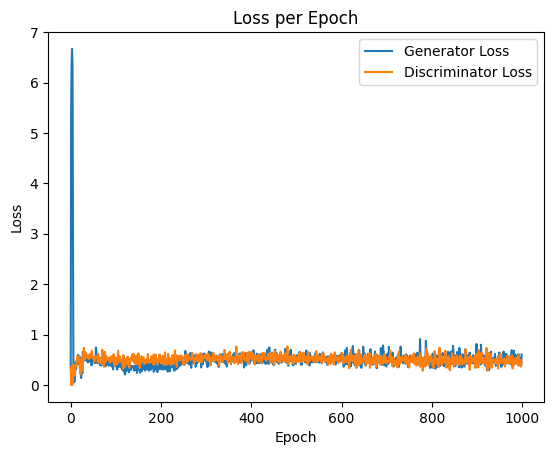

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Step 1: Read the .log file and extract the losses per epoch
with open('./train.log', 'r') as f:
    lines = f.readlines()

losses = []
losses1 = []
for i in range(4592, 18592):
    if 'train/fake' in lines[i]:
        loss = float(lines[i].split()[-1])
        losses.append(loss)
    if 'train/real' in lines[i] and 'train/real_adv_cls' not in lines[i]:
        loss1 = float(lines[i].split()[-1])
        losses1.append(loss1)

# Step 2: Store the losses in a suitable data structure
losses = np.array(losses)
losses1 = np.array(losses1)
# Step 3: Create a plot of the losses
plt.figure()
plt.plot(losses, label='Generator Loss')
plt.plot(losses1, label='Discriminator Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend(loc='best')
plt.show()

In [ ]:
# with open('./train.log', 'r') as f:
#     lines = f.readlines()

# losses = []
# for i in range(4592, 18592):
#     if 'train/real' in lines[i] and 'train/real_adv_cls' not in lines[i]:
#         loss = float(lines[i].split()[-1])
#         losses.append(loss)

# # Step 2: Store the losses in a suitable data structure
# losses = np.array(losses)

# # Step 3: Create a plot of the losses
# plt.plot(losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss per Epoch')
# plt.show()

In [ ]:
# lines[4592]
# lines[18592]